Questo notebook consente l'analisi di un singolo fornitore.
Per analizzare le statistiche di un fornitore per l'anno 2017, caricare il file *data/anac/anac_indicepa_2017.tsv*. Per analizzare le statistiche di un fornitore su tutto il dataset, caricare il file *data/anac/anac_indicepa_all.tsv*


In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy
import csv
import datetime

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [2]:
def getTopNWord(data, N):
    class StemmedCountVectorizer(TfidfVectorizer):
    
        def build_analyzer(self):
            analyzer = super(StemmedCountVectorizer, self).build_analyzer()
            return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

    tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', max_features=100, stop_words = stopwords.words('italian'), sublinear_tf=True)

    #tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', max_features=100, stop_words = stopwords.words('italian'), sublinear_tf=True)
    #tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', max_features=100, stop_words = stopwords.words('italian'), sublinear_tf=True)
   
    tfidf_matrix =  tf.fit_transform(data)
    
    score_tf = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
    sorted_scores_tf = sorted(score_tf, key=lambda x: x[1], reverse=True)

    total = time() - t0
    print("TF-IDF matrix generated in " + str(total) + " sec")
    print("Matrix Size: ",tfidf_matrix.shape)
    
    return sorted_scores_tf[0:N]
    

In [3]:
def normalize(df):
    return df.index / df.index.values.sum()

def showPlot(df, col, cfPrimoaggiudicatario):
   
    data = df[[col,"count", "importoAggiudicazione"]].groupby([col]).sum().reset_index()
    importo_normalized = data.importoAggiudicazione / data.importoAggiudicazione.sum()
    count_normalized = data["count"] / data["count"].sum()
    
    data = [go.Bar(x=data[col], y=count_normalized, name = "importoAggiudicazione"),
            go.Bar(x=data[col], y=importo_normalized, name = "numero gare vinte")
           ]
    bar = go.Layout(title= col,yaxis=dict(title='',))

    fig_bar = go.Figure(data=data, layout=bar)

    #py.iplot(fig_bar)
    
    return fig_bar

In [4]:
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321761 entries, 0 to 1321760
Data columns (total 24 columns):
cfStrutturaProponente                1321761 non-null int64
cig                                  1321754 non-null object
denominazioneStrutturaProponente     1321602 non-null object
oggetto                              1321651 non-null object
sceltaContraente                     1321758 non-null object
importoAggiudicazione                1321760 non-null float64
importoSommeLiquidate                1321760 non-null float64
dataInizio                           1321761 non-null object
dataUltimazione                      1148870 non-null object
jsonPartecipanti                     1321761 non-null object
jsonAggiudicatari                    1321761 non-null object
totalePartecipanti                   1321761 non-null int64
totaleAggiudicatari                  1321761 non-null int64
totaleRaggruppamentopartecipanti     1321761 non-null int64
totaleRaggruppamentoAggiudicatari  

## Setting aggiudicatario da analizzare

In [6]:
cfPrimoaggiudicatario = "00488410010"

In [7]:
df_aggiudicatario = df.loc[df["cfPrimoaggiudicatario"] == cfPrimoaggiudicatario]
df_aggiudicatario['dataInizio'] = pd.to_datetime(df_aggiudicatario['dataInizio'], errors='coerce')
df_aggiudicatario['mese_aggiudicazione'] = df_aggiudicatario['dataInizio'].map(lambda x: str(x.month))

/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [8]:
#describe numeric attributes
df_aggiudicatario.describe()

,cfStrutturaProponente,importoAggiudicazione,importoSommeLiquidate,totalePartecipanti,totaleAggiudicatari,totaleRaggruppamentopartecipanti,totaleRaggruppamentoAggiudicatari
count,8.281000e+03,8.281000e+03,8.281000e+03,8281.000000,8281.000000,8281.0,8281.000000
mean,6.622440e+10,1.019548e+04,2.615871e+03,1.064123,1.023789,0.0,0.000121
std,3.620409e+10,3.784445e+05,3.237409e+04,0.878277,0.233207,0.0,0.010989
min,3.887094e+07,0.000000e+00,0.000000e+00,0.000000,1.000000,0.0,0.000000
25%,8.000248e+10,1.083600e+02,5.504000e+01,1.000000,1.000000,0.0,0.000000
50%,8.100097e+10,2.798900e+02,1.476300e+02,1.000000,1.000000,0.0,0.000000
75%,9.022966e+10,1.551820e+03,6.186800e+02,1.000000,1.000000,0.0,0.000000
max,9.809413e+10,3.400000e+07,1.753850e+06,37.000000,15.000000,0.0,1.000000


### Bandi di gara Vinti

Campi analizzati:
1. totaleRaggruppamentopartecipanti: numero di raggruppamenti partecipanti ad un bando di gara; 
2. totalePartecipanti: numero di partecipanti (non raggruppamento) ad un bando di gara; 
3. mese_aggiudicazione: mese in cui è stata aggiudicata la gara; 
4. denominazioneStrutturaProponente: denominazione struttura proponente;
5. tipologia_istat: tipologia istat della struttura proponente;
6. regione: regione di appartenenza della struttura proponente;
7. provincia: provincia di appartenenza della struttura proponente;
8. comune: comune di appartenenza della struttura proponente;

In [9]:
df_aggiudicatario['dataInizio'] = pd.to_datetime(df['dataInizio'], errors='coerce')
df_aggiudicatario['YearMonth'] = df_aggiudicatario['dataInizio'].map(lambda x: 100*x.year + x.month)
df_aggiudicatario.cfStrutturaProponente = df_aggiudicatario.cfStrutturaProponente.astype('category')

/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/fabiana/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

## Vista dataset raggruppata per struttura proponente 

In [10]:
df_aggiudicatario_count = df_aggiudicatario.groupby(["cfStrutturaProponente"])["cfStrutturaProponente"].agg(["count"]).reset_index(0)#.sort_values(['count'], ascending=False)
df_aggiudicatario_sum = df_aggiudicatario[["importoSommeLiquidate","importoAggiudicazione", "cfStrutturaProponente"]].groupby(["cfStrutturaProponente"]).sum().reset_index()

df_join = df_aggiudicatario_count.set_index('cfStrutturaProponente').join(df_aggiudicatario_sum.set_index('cfStrutturaProponente'))

columns_to_add = ["totaleRaggruppamentopartecipanti","totalePartecipanti","mese_aggiudicazione","dataInizio","cfStrutturaProponente","denominazioneStrutturaProponente", "tipologia_istat", "regione", "provincia", "comune"]
df_denominazione_aggiudicatario = df_aggiudicatario[columns_to_add]
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario.set_index("cfStrutturaProponente")
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario[~df_denominazione_aggiudicatario.index.duplicated(keep='first')]

final_df = pd.merge(df_join,df_denominazione_aggiudicatario, left_index=True, right_index=True, how='left')

final_df =final_df.reset_index()

In [11]:
final_df[["denominazioneStrutturaProponente", "importoSommeLiquidate", "importoAggiudicazione", "tipologia_istat", "regione", "provincia", "mese_aggiudicazione"]].head(3)

,denominazioneStrutturaProponente,importoSommeLiquidate,importoAggiudicazione,tipologia_istat,regione,provincia,mese_aggiudicazione
0,COMUNE DI CARPINONE,2461.15,4200.00,Comuni e loro Consorzi e Associazioni,Molise,IS,3
1,CDATAIstituto Autonomo per le Case Popolari d...,772.33,8623.80,Aziende e Consorzi Pubblici Territoriali per l...,Sicilia,CL,12
2,ARCA Nord Salento,0.00,9819.96,Aziende e Consorzi Pubblici Territoriali per l...,Puglia,BR,7


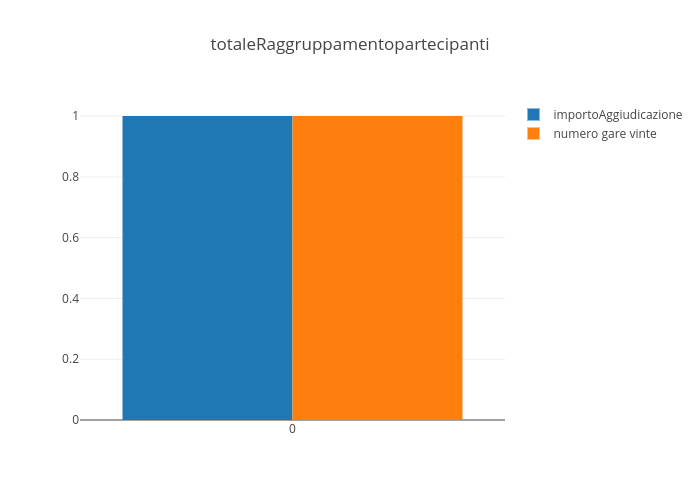

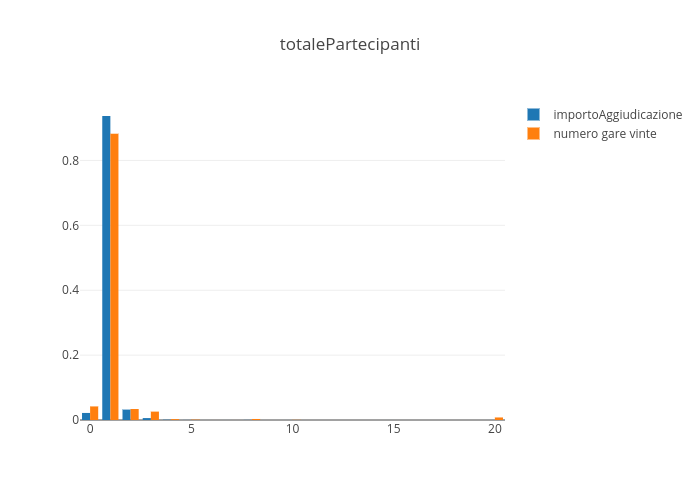

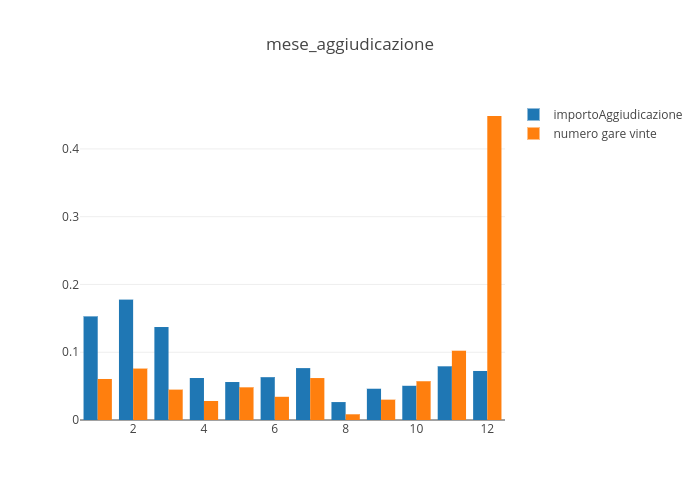

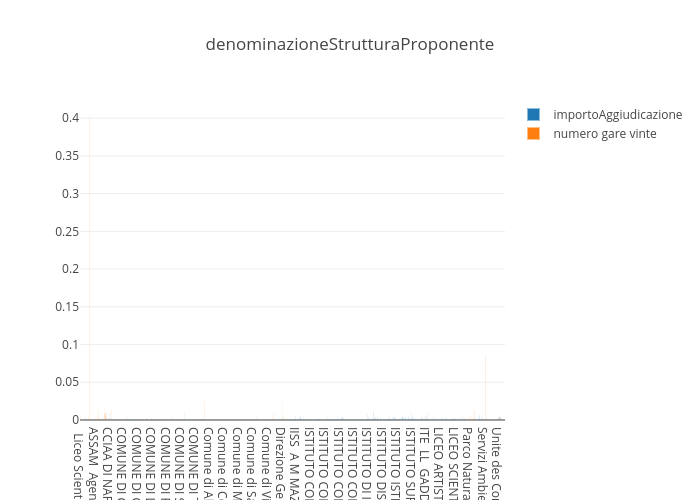

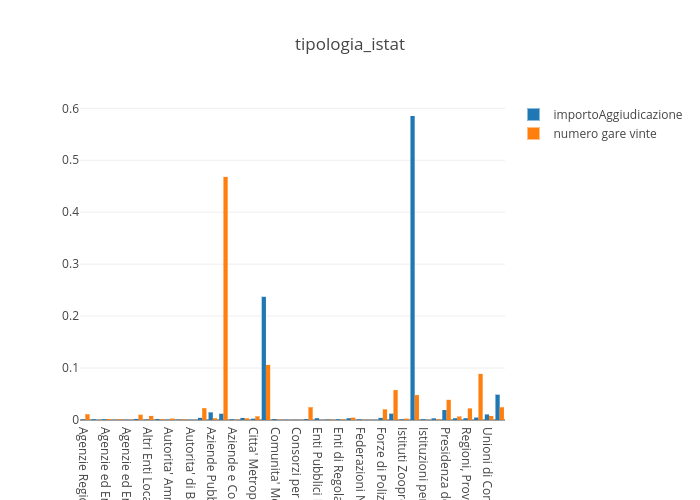

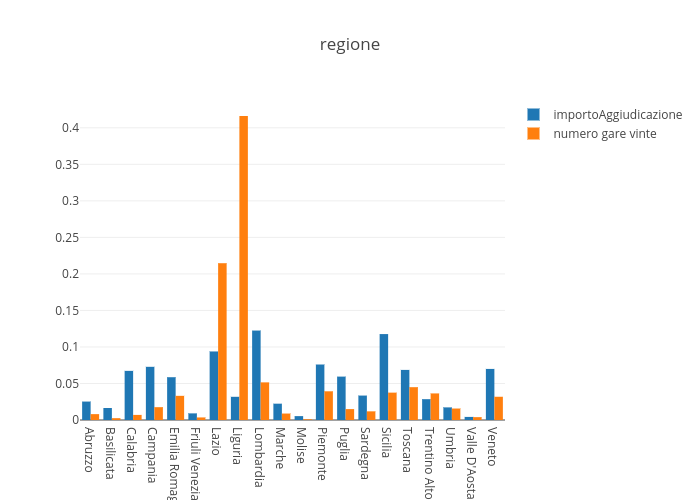

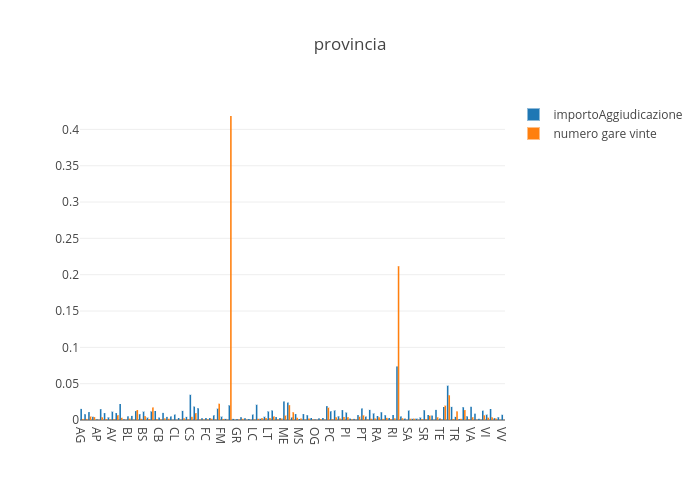

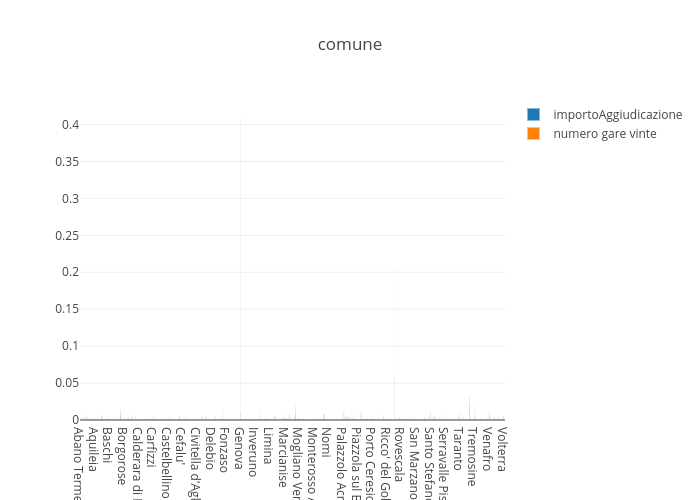

In [13]:
columns_to_visualize = ["totaleRaggruppamentopartecipanti","totalePartecipanti","mese_aggiudicazione","denominazioneStrutturaProponente", "tipologia_istat", "regione", "provincia", "comune"]
#columns_to_visualize = ["totalePartecipanti"]

for col in columns_to_visualize:
    fig_bar = showPlot(final_df, col, cfPrimoaggiudicatario)
    
    fig_bar_path = 'imgs/' +col+".png"
    py_on.image.save_as(fig_bar, filename=fig_bar_path)

    #py.iplot(fig_bar)
    i = Image(fig_bar_path)
    display(i)

## Analisi informazioni non strutturate
Si analizzano di seguito le informazioni non strutturate associate all'oggetto delle gare del fornitore in analisi:
- Termini piu frequenti;
- Distribuzione dei documenti in funzione dei termini;

Per maggiori dettagli vedi notebook [5_Analisi_topic.ipynb]()

In [14]:
print("Initial dataset size ",df_aggiudicatario.shape)
df_aggiudicatario = df_aggiudicatario.dropna(subset=["oggetto"])
data = df_aggiudicatario["oggetto"]
print("Dataset size after removing empty elements: ",df_aggiudicatario.shape)

Initial dataset size  (8281, 26)
Dataset size after removing empty elements:  (8280, 26)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
from nltk.stem.snowball import ItalianStemmer
from time import time

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

t0 = time()

italian_stemmer = ItalianStemmer()


class StemmedCountVectorizer(TfidfVectorizer):
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        
tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', max_features=1000, analyzer="word", stop_words=stopwords.words('italian'))

#tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', max_features=1000, stop_words = stopwords.words('italian'), sublinear_tf=True)
tfidf_matrix =  tf.fit_transform(data)

total = time() - t0
print("TF-IDF matrix generated in " + str(total) + " sec")
print("Matrix Size: ",tfidf_matrix.shape)

TF-IDF matrix generated in 2.598526954650879 sec
Matrix Size:  (8280, 1000)


In [16]:
def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words[1:N]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)

    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'    
    plt.savefig(file_name) #png

    plt.clf
    return file_name

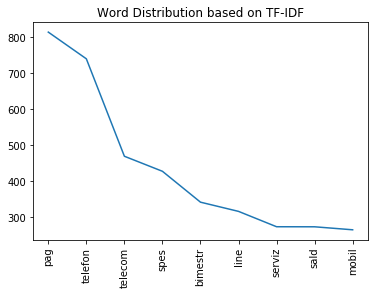

In [17]:
top_terms = 10

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

### Visualizzazione documenti
Se il numero di documenti è > 100 applichiamo tecniche di clustering per raggruppare i documenti in classi sintatticamente simili

In [18]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


if tfidf_matrix.shape[0] > 100:
    #Standardize features by removing the mean and scaling to unit variance
    t0 = time()
    scaled_tfidf_matrix = StandardScaler().fit_transform(tfidf_matrix.toarray())
    total = time() - t0
    print("Standardization done in %0.3f sec" % total)
    
    # Compute DBSCAN
    t0 = time()
    db = DBSCAN(eps=0.5, min_samples=10).fit(scaled_tfidf_matrix)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    total = time() - t0
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clustering done in done in %0.3f sec" % total)
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(scaled_tfidf_matrix, labels))
    
    df_aggiudicatario["label"] = labels

Standardization done in 0.429 sec
Clustering done in done in 33.460 sec
Estimated number of clusters: 47
Silhouette Coefficient: 0.018


In [19]:
from sklearn.manifold import TSNE

t0 = time()
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())
total = time() - t0

print("TSNE done in "+ str(total) + " sec")

TSNE done in 440.8011620044708 sec


In [20]:
sample = 10000
x, y = zip(*tsne_results)
df_aggiudicatario["X"] = x
df_aggiudicatario["Y"] = y
df_aggiudicatario_sample = df_aggiudicatario[df_aggiudicatario["label"] != -1].head(sample)

In [21]:
scatter = [go.Scatter(
    name = "TSNE",
    x=df_aggiudicatario_sample["X"],
    y=df_aggiudicatario_sample["Y"],
    text=df_aggiudicatario_sample.oggetto,
    mode='markers',
    marker=dict(
        size=4,
        color=df_aggiudicatario_sample.label,
        line=dict(
        color=df_aggiudicatario_sample.label,
        width=1
        )
        #,opacity=0.8
    ))]
    

fig = go.Figure(data=scatter)
#py.iplot(fig)

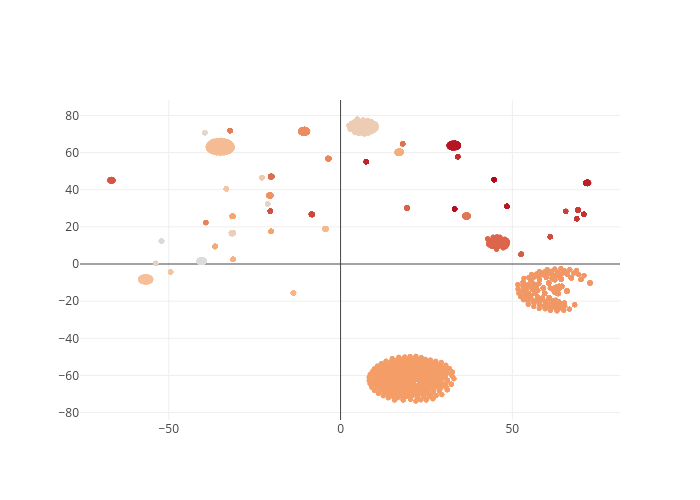

In [23]:
fig_tsne_path = "imgs/tsne.png"
py_on.image.save_as(fig, filename=fig_tsne_path)

i = Image(fig_tsne_path)
display(i)

In [24]:
documents_distribution = pd.DataFrame(df_aggiudicatario["label"].value_counts())
words = []
for label in documents_distribution.index:
    df_aggiudicatario_label = df_aggiudicatario[df_aggiudicatario["label"] == label]
    top_words = getTopNWord(df_aggiudicatario_label["oggetto"], 10)
    string = " ".join([x for x,y in top_words])
    print("label: "+ str(label) + " top_words: " + string)
    words.append(string)

documents_distribution["top_frequent_words"] = words

TF-IDF matrix generated in 529.2195730209351 sec
Matrix Size:  (5795, 100)
label: -1 top_words: telefon fattur pag telecom line spes bimestr serviz bim mobil
TF-IDF matrix generated in 529.2679362297058 sec
Matrix Size:  (696, 9)
label: 20 top_words: fattur allend cavallasc dek fp pis telecompag cavsc scprim
TF-IDF matrix generated in 529.3476188182831 sec
Matrix Size:  (562, 5)
label: 19 top_words: fattur pag dicgennai nxl xa
TF-IDF matrix generated in 529.3716759681702 sec
Matrix Size:  (134, 6)
label: 6 top_words: fattur pag telecom giob scin xa
TF-IDF matrix generated in 529.3939759731293 sec
Matrix Size:  (115, 5)
label: 11 top_words: spes telefon gprs giudic pac
TF-IDF matrix generated in 529.4151902198792 sec
Matrix Size:  (104, 4)
label: 29 top_words: fattur sald nh ponfesrpu
TF-IDF matrix generated in 529.4300580024719 sec
Matrix Size:  (68, 10)
label: 10 top_words: mobil telefon procur repubbl beitritts bis consipkonvention des verlngerung zum
TF-IDF matrix generated in 529.4

In [25]:
documents_distribution.head()

,label,top_frequent_words
-1,5795,telefon fattur pag telecom line spes bimestr s...
20,696,fattur allend cavallasc dek fp pis telecompag ...
19,562,fattur pag dicgennai nxl xa
6,134,fattur pag telecom giob scin xa
11,115,spes telefon gprs giudic pac


## Next Steps:

1. Aggiungere i competitor del fornitore in analisi
2. Analizzare i campi jsonPartecipanti e jsonAggiudicatari in modo da ottenere statistiche anche sui bandi in cui un fornitore ha partecipato ma non vinto;
3. Associare ai campi in analisi anche statistiche circa l'importo di aggiudicazione (media, somma, max, min);
4. Per data record su raggruppamenti applicare algoritmi di frequent itemset mining in modo da scoprire se ci sono pattern ricorrenti nei raggruppamenti;